In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from os.path import dirname, abspath, join, exists

from clearml import Task, OutputModel

from amplify.data import DataGenerator, DataSplit

## Load Data

In [2]:
# DataGenerator - ClearML
xy_data = DataGenerator().load_data()
xy_data.shape

Info: Successfully loaded Building data!
Info: Successfully loaded Weather data!
Successfully merged Building and Weather data!
Successfully added Azimuth and Irradiance data!


(1994, 7)

## Data Processing

In [3]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="encoder-decoder-lstm", ) # output_uri="s3://amplify-microgrid-ai")

ClearML Task: created new task id=9bb452f9cc614f79bbcf26c63144fe88
2022-02-01 03:24:11,086 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/f0e0b096252d4c18b9005e580afc5bce/experiments/9bb452f9cc614f79bbcf26c63144fe88/output/log


In [4]:
# Data Split parameters 
SERIES = 48
STRIDE = 1

In [5]:
# Data Shape 
# Batch Size of 10
# Series of 7 Days 168
# (B,  S,   H, F) <-X Y-> (B,  S,   H, O)
# (20, 30, 48, 5) <-X Y-> (20, 30, 48, 1)

# |0| |2|3| |5|6|7|8|9|
#    T     V 

# This is for solar only, for now
train_ds, val_ds, test_ds = DataSplit(xy_data, series_length=SERIES, stride=STRIDE).split_data()

Successfully split data into (train_x, train_y), (val_x, val_y), (test_x, test_y) tuples!


In [6]:
# Isolate XY from datasets
x_train, y_train,  = (
    train_ds[0],
    train_ds[1],
)  # Training data
x_val, y_val = (
    val_ds[0],
    val_ds[1],
)  # Validation data
x_test, y_test = (
    test_ds[0],
    test_ds[1],
)  # Test data


### Reviewing Data

In [7]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)


x_train shape:  (1547, 48, 5)
y_train shape:  (1547, 48, 2)


## Modeling

In [8]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, Normalization, TimeDistributed

### Normalize Data

## Encoder/Decoder LSTM

In [9]:
# Normalize to x_train data
norm_layer = Normalization(axis=-2)
norm_layer.adapt(x_train)

# Define the model 
norm_inputs = Input(shape=(SERIES, x_train.shape[-1]))
encoder_inputs = norm_layer(norm_inputs)
encoder_l1 = LSTM(10*SERIES, return_state=True, dropout=.25)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = RepeatVector(SERIES)(encoder_outputs1[0])

decoder_l1 = LSTM(10*SERIES, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
decoder_outputs1 = TimeDistributed(Dense(y_train.shape[-1], activation='relu'))(decoder_l1)

model = Model(norm_inputs, decoder_outputs1)

2022-02-01 03:24:22.291567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 03:24:22.297833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 03:24:22.298500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 03:24:22.299659: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 5)]      0           []                               
                                                                                                  
 normalization (Normalization)  (None, 48, 5)        97          ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 480),        933120      ['normalization[0][0]']          
                                 (None, 480),                                                     
                                 (None, 480)]                                                     
                                                                                              

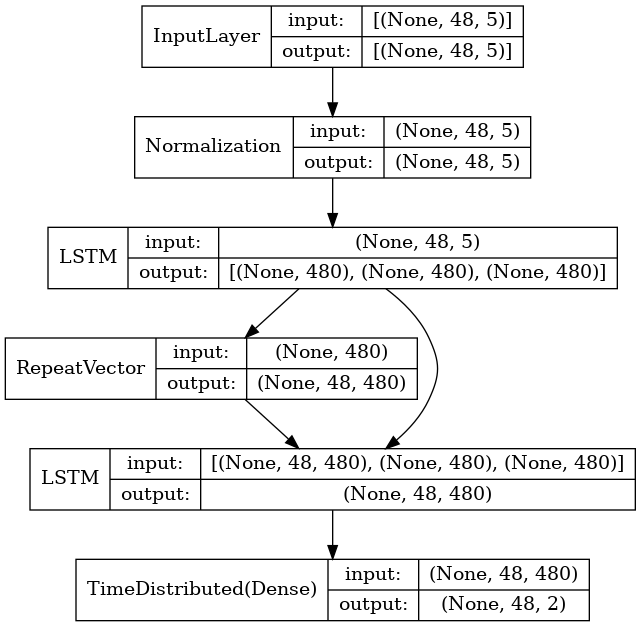

In [10]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [11]:
# Hyperparameters and callbacks

BATCH  = 1
EPOCHS = 100
FACTOR = .9
PATIENCE = 5

log_dir = os.path.join('../','logs')
model_path = os.path.join('../', 'models', "lstm_weights.hdf5")

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, 
        monitor="val_loss",
        mode='min',
        save_best_only=True, 
        save_weights_only=True, 
        
        verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        mode='min', 
        factor=FACTOR,
        patience=PATIENCE, 
        min_lr=1e-8, 
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode='min', 
        patience=5*PATIENCE, 
        verbose=1)
]

In [12]:
# try:
#     model.load_weights(model_path)
# except Exception:
#     pass

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    #loss=tf.keras.losses.Huber(), # Less sensitive to outliers 
    loss=tf.keras.losses.MeanSquaredError(),  # More sensitive to outliers 
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/100


2022-02-01 03:24:27.085753: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


1542/1547 [============================>.] - ETA: 0s - loss: 64.0610 - root_mean_squared_error: 8.0038
Epoch 00001: val_loss improved from inf to 36.28751, saving model to ../models/lstm_weights.hdf5
2022-02-01 03:24:44,345 - clearml.frameworks - INFO - Found existing registered model id=d204bdccfb964c53a06d28f5505a62b4 [/home/vscode/amplify-microgrid-ai/models/lstm_weights.hdf5] reusing it.
1547/1547 [==============================] - 22s 12ms/step - loss: 64.0664 - root_mean_squared_error: 8.0041 - val_loss: 36.2875 - val_root_mean_squared_error: 6.0239 - lr: 0.0010
Epoch 2/100
1546/1547 [============================>.] - ETA: 0s - loss: 63.3187 - root_mean_squared_error: 7.9573
Epoch 00002: val_loss improved from 36.28751 to 33.04338, saving model to ../models/lstm_weights.hdf5
1547/1547 [==============================] - 18s 12ms/step - loss: 63.3073 - root_mean_squared_error: 7.9566 - val_loss: 33.0434 - val_root_mean_squared_error: 5.7483 - lr: 0.0010
Epoch 3/100
1545/1547 [=====

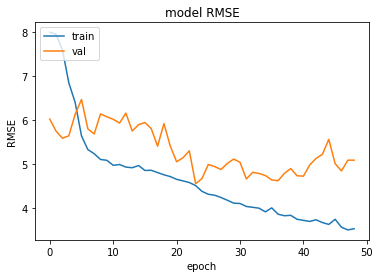

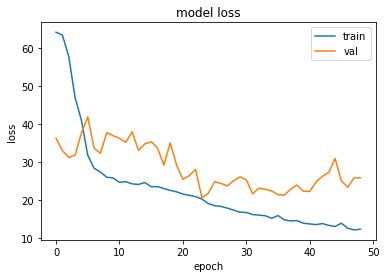

In [13]:
def plot_history(history, metric):
    # This function will plot the model fit process
    # summarize history for accuracy
    if metric == "root_mean_squared_error":
        plt.plot(history.history['root_mean_squared_error'])
        plt.plot(history.history['val_root_mean_squared_error'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif metric == "mean_absolute_percentage_error":
        plt.plot(history.history["mean_absolute_percentage_error"])
        plt.plot(history.history["val_mean_absolute_percentage_error"])
        plt.title('model MAPE')
        plt.ylabel('MAPE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    elif metric == "mean_absolute_error":
        plt.plot(history.history["mean_absolute_error"])
        plt.plot(history.history["val_mean_absolute_error"])
        plt.title('model MAE')
        plt.ylabel('MAE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

plot_history(history, 'root_mean_squared_error')

In [14]:
# Evaluate and make predictions
model.load_weights(model_path)
scores = model.evaluate(x_val, y_val, verbose=1, batch_size=BATCH, callbacks=callbacks)
scores = model.evaluate(x_test, y_test, verbose=1, batch_size=BATCH, callbacks=callbacks)
y_preds = model.predict(x_test, verbose=1, batch_size=BATCH, callbacks=callbacks)


151/151 [==============================] - 1s 4ms/step


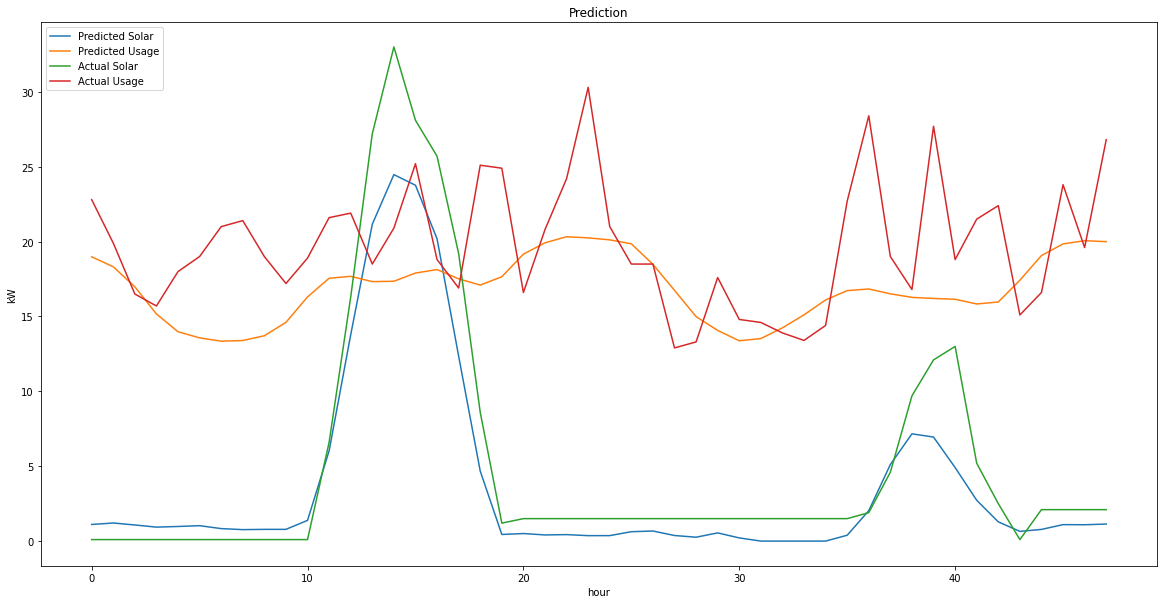

In [23]:
plt.figure(figsize=(20, 10))
plt.title('Prediction')
x = np.random.default_rng().integers(0, y_preds.shape[0])
plt.plot(y_preds[x,:,:])
plt.plot(y_test[x,:,:])
plt.ylabel('kW')
plt.xlabel('hour')
plt.legend(['Predicted Solar', 'Predicted Usage', 'Actual Solar', 'Actual Usage'], loc='upper left')

plt.show()

In [16]:
task.close()